In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import multiprocessing
from transformers import DistilBertTokenizer, DistilBertModel, AdamW, get_linear_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup
from tqdm.notebook import tqdm
from common import Common, Timer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import random

In [10]:
PATH = 'C:/Users/bill/Documents/projects/data/chatbot'
MAX_WORKERS = multiprocessing.cpu_count() - 1
B = 32
E = 10
T = 500
Y = 199

In [3]:
train_df = pd.read_csv(os.path.join(PATH, 'train.tsv'), sep='\t')[['utterance', 'intent']].dropna().reset_index(drop=True)
valid_df = pd.read_csv(os.path.join(PATH, 'valid.tsv'), sep='\t')[['utterance', 'intent']].dropna().reset_index(drop=True)

intents = LabelEncoder()
intents.fit(pd.concat([ train_df['intent'], valid_df['intent'] ]))
train_df['intent'] = intents.transform(train_df['intent'])
valid_df['intent'] = intents.transform(valid_df['intent'])

# to ensure that BERT will run without problem on sequence length
train_df['utterance'] = train_df['utterance'].apply(lambda x : x[:T])
test_df['utterance'] = test_df['utterance'].apply(lambda x : x[:T])
    
itrain = Common.generator(train_df['utterance'], train_df['intent'], B)
ivalid = Common.generator(valid_df['utterance'], valid_df['intent'], B)

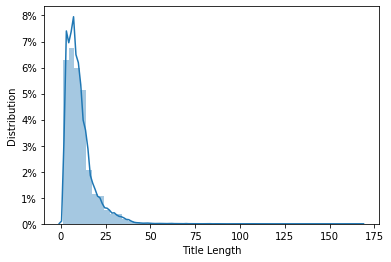

In [4]:
x = pd.concat([train_df['utterance'], valid_df['utterance']])
ax = sns.distplot(x.str.split().apply(len))
ax.set(xlabel='Title Length', ylabel='Distribution')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
plt.show()

In [7]:
class Model(nn.Module):
    
    #model = 'distilbert-base-cased'
    def __init__(self, model, T, Y):
        super(Model, self).__init__()
        self.T = T
        self.tokenizer = DistilBertTokenizer.from_pretrained(model, do_lower_case=True)
        self.model = DistilBertModel.from_pretrained(model)
        self.linear = nn.Linear(768, Y)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, inputs, device):
        tokens = self.tokenizer.batch_encode_plus(
            inputs, 
            add_special_tokens=True, 
            return_tensors='pt', 
            pad_to_max_length=True,
            #max_length=self.T,
            return_attention_masks=False
        )['input_ids'].to(device)
        #with torch.no_grad():
        output = self.model(tokens)[0][:,0,:]
        #output = torch.flatten(output, start_dim=1)
        output = self.dropout(output)
        output = self.linear(output)
        return output
    
def scoring(device, model, criterion, iterator):
    with torch.no_grad():
        total_loss = []
        total_accy = []
        for x, y in iterator:
            scores = model(x, device)
            loss = criterion(scores, y.to(device).long())
            total_loss.append(loss.item())
            total_accy.append(Common.accuracy(scores, y, device))
    return np.mean(total_loss), np.mean(total_accy)

In [8]:
device = Common.device()
model = Model('distilbert-base-uncased', T, Y).to(device)
optimizer = AdamW(model.parameters(),
    lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)
criterion = Common.criterion()

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 1, # Default value in run_glue.py
    num_training_steps = len(itrain) * E)

#schedular = CosineAnnealingLR(optimizer, T_max=2)

seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# best_loss = 999
# best_model = None
# best_epoch = 0

for epoch in range(E):
    t = Timer()
    total_loss = []
    total_accy = []
    for x, y in tqdm(itrain):
        
        # step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # step 3. Run our forward pass.
        scores = model(x, device)

        # step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(scores, y.to(device).long())
        total_loss.append(loss.item())
        #total_accy.append(sum(torch.argmax(scores, axis=1) == y.to(device)).true_divide(len(y)).item())
        total_accy.append(Common.accuracy(scores, y, device))

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
    train_loss, train_accy = np.mean(total_loss), np.mean(total_accy)
    valid_loss, valid_accy = scoring(device, model, criterion, ivalid)

#     if valid_loss < best_loss:
#         Common.save_checkpoint({
#             'loss': valid_loss,
#             'accuracy': valid_accy,
#             'state_dict': model.state_dict(),
#             'optimizer': optimizer.state_dict(),
#         }, './models/model.tar')
#         best_model = model
#         best_epoch = epoch
#         best_loss = valid_loss

    print(', '.join([
        'epoch: {}'.format(epoch),
        'train_loss: {:3.2}'.format(train_loss),
        'valid_loss: {:3.2}'.format(valid_loss),
        'train_accy: {:3.2%}'.format(train_accy),
        'valid_accy: {:3.2%}'.format(valid_accy),
        'time: {}'.format(t.get())
    ]))

# test_loss, test_accy = scoring(device, best_model, criterion, itest)
# Log.info(', '.join([
#         'best_epoch: {}'.format(best_epoch),
#         'test_loss: {:3.2}'.format(test_loss),
#         'test_accy: {:3.2}'.format(test_accy)
#     ]))


epoch: 0, train_loss: 1.3, valid_loss: 1.0, train_accy: 72.49%, valid_accy: 77.64%, time: 00:04:34



epoch: 1, train_loss: 0.39, valid_loss: 0.94, train_accy: 90.30%, valid_accy: 78.90%, time: 00:04:34



epoch: 2, train_loss: 0.18, valid_loss: 0.99, train_accy: 95.26%, valid_accy: 78.89%, time: 00:04:33



epoch: 3, train_loss: 0.081, valid_loss: 1.1, train_accy: 97.90%, valid_accy: 79.55%, time: 00:04:32



epoch: 4, train_loss: 0.035, valid_loss: 1.3, train_accy: 99.08%, valid_accy: 78.24%, time: 00:04:29



epoch: 5, train_loss: 0.015, valid_loss: 1.3, train_accy: 99.64%, valid_accy: 79.10%, time: 00:04:25



epoch: 6, train_loss: 0.0096, valid_loss: 1.4, train_accy: 99.76%, valid_accy: 79.25%, time: 00:04:23



epoch: 7, train_loss: 0.0053, valid_loss: 1.4, train_accy: 99.88%, valid_accy: 78.87%, time: 00:04:22



epoch: 8, train_loss: 0.0036, valid_loss: 1.4, train_accy: 99.92%, valid_accy: 79.39%, time: 00:04:23



epoch: 9, train_loss: 0.0016, valid_loss: 1.5, train_accy: 99.95%, valid_accy: 79.47%, time: 00:04:23


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [4]:
inputs = [
    'change of address but not effective till 9 / 22',
    'my cat sucks really bad',
    'my day is going well',
    'Here is the sentence I want embeddings for.'
]
tokens = tokenizer.batch_encode_plus(
    inputs, 
    add_special_tokens=True, 
    return_tensors='pt', 
    pad_to_max_length=True,
    max_length=50,
    return_attention_masks=False
)

print(tokens)

#for token in tokens:
#    print(tokenizer.convert_ids_to_tokens(token))
# tokens = []
# for x in inputs:
#     tokens.append(torch.tensor(tokenizer.encode(x, add_special_tokens=True, max_length=T, pad_to_max_length=True)))
    
# tokens = torch.stack(tokens).to(device)
# _, output = model(**tokens)
#output = torch.flatten(output, start_dim=1)

{'input_ids': tensor([[  101,  2689,  1997,  4769,  2021,  2025,  4621,  6229,  1023,  1013,
          2570,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2026,  4937, 19237,  2428,  2919,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2026,  2154,  2003,  2183,  2092,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,